In [1]:
import matplotlib.pylab as plt
import yaml
import csv
import datetime
from nupic.algorithms import anomaly_likelihood
from nupic.frameworks.opf.model_factory import ModelFactory
import best_model_params as modelParams

# Convery .py to .yml param file
with open('modelParams.yml', 'w') as outfile:
    yaml.dump(modelParams.MODEL_PARAMS, outfile, default_flow_style=False)
    
_PARAMS_PATH = "/home/codepan1/RestRunnerCode/modelParams.yml"
    
with open(_PARAMS_PATH, "r") as f:
    modelParams = yaml.safe_load(f)
    
# Create OPF Model & Load parameters into model space
model = ModelFactory.create(modelParams)

# What to predict?
model.enableInference({'predictedField': 'consumption'})

# Open the file to loop over each row to feed model
output = []
anomaly_score = []
prediction = []
confidence = []
anomaly_Likelihood = []
anomaly_logLikelihood = []
anomaly_likelihood_helper = anomaly_likelihood.AnomalyLikelihood()
input_data = []
with open ("sim_data.csv") as fileIn:
    reader = csv.reader(fileIn)
    # The first two rows are not data, but we'll need the field names when passing data into the model.
    headers = reader.next()
    reader.next()
    reader.next()

    # loop through data rows
    for record in reader:
        # Save input data for plotting
        input_data.append(record)
        
        # Create a dictionary with field names as keys, row values as values.
        modelInput = dict(zip(headers, record))
        
        # Convert string consumption to float value.
        modelInput['consumption'] = float(modelInput['consumption'])
        
        # Convert timestamp string to Python datetime.
        modelInput["timestamp"] = datetime.datetime.strptime(
          modelInput["timestamp"], "%Y-%m-%d %H:%M:%S")
        
        # Push the data into the model and get back results.
        result = model.run(modelInput)
        
        # Save predicition history in new file
        output.append(result.inferences['multiStepBestPredictions'][1])
        
        anomaly_score_r = result.inferences["anomalyScore"]
        
        prediction_r = result.inferences["multiStepBestPredictions"][1]
        
        confidence.append(result.inferences["multiStepPredictions"][1][prediction_r])
        
        anomaly_Likelihood_r = anomaly_likelihood_helper.anomalyProbability(
                    modelInput['consumption'], anomaly_score_r, modelInput['timestamp'])
        
        anomaly_logLikelihood_r = anomaly_likelihood_helper.computeLogLikelihood(anomaly_Likelihood_r)
        
        #store for later
        anomaly_score.append(anomaly_score_r)
        prediction.append(prediction_r)
        anomaly_Likelihood.append(anomaly_Likelihood_r)
        anomaly_logLikelihood.append(anomaly_logLikelihood_r)


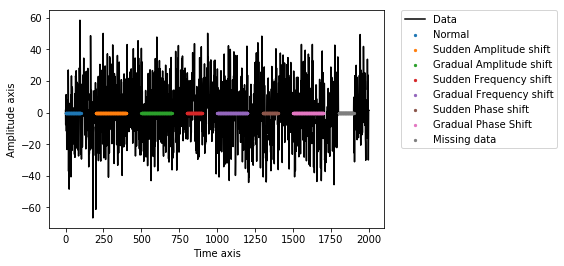

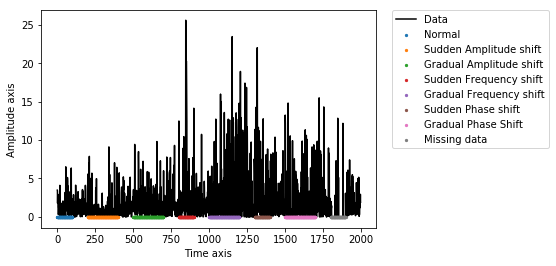

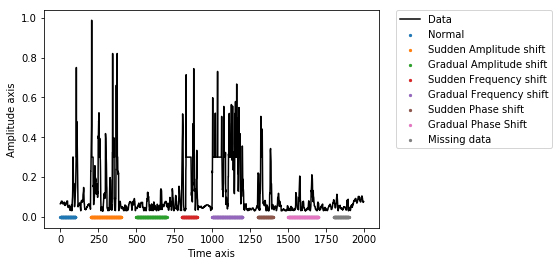

In [2]:
import numpy as np
import SimAnomalyDataset as pie
from evaluatePredictions import main

# get anomaly locations from simulation
data, anomaly_loc, anomaly_dur, dates = pie.get_data()

# slight data transformation
a = np.asarray(input_data)
a = a[:,2].astype(np.float)

OUT = main(test=a[8000:], pred=prediction[8000:], metric = "RMSE")

#RMSE plot
pie.plot_data(OUT, anomaly_loc, anomaly_dur)

#anomaly likelihoods
pie.plot_data(anomaly_logLikelihood[8000:], anomaly_loc, anomaly_dur)